In [5]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

def getActivePlayers(stats, year, buffer):
    # list of name of the players who were active in this and last year
    thisYear = stats[stats.Year == year].copy()
    players = list(thisYear.Player.unique())
    for i in range(1, buffer+1):
        previousYear = stats[stats.Year == (year-i)].copy()
        players = list(set(players) & set(previousYear.Player.unique()))
    return players

def topPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player","player_id"]][:n]

def removeDuplicated(players, stats):
    """
    players: "../data/nba-players-stats/player_data.csv"
    stats: "../data/nba-players-stats/Seasons_Stats.csv"
    """
    # players with the same name
    names = players.name.unique()
    duplicated = np.array([])

    for name in names:
        numrows = len(players[players.name == name])
        if numrows != 1:
            duplicated = np.append(duplicated, name)

    duplicated = np.sort(duplicated)

    start_year = players.copy()
    start_year = start_year.rename(columns={"name":"Player"})

    # for non-duplicated players
    stats_not_duplicated = stats[~stats.Player.isin(duplicated)]
    stats_not_duplicated = pd.merge(stats_not_duplicated, start_year, on="Player", how="left")

    # only take the values that make sense
    stats_not_duplicated = stats_not_duplicated[(stats_not_duplicated.Year >= stats_not_duplicated.year_start) & (stats_not_duplicated.Year <= stats_not_duplicated.year_end )]
    stats_not_duplicated["year_count"] = stats_not_duplicated.Year - stats_not_duplicated.year_start

    return stats_not_duplicated

"""
import data
"""
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980
players["player_id"] = range(0,len(players.name)) # assign id

stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int)

# transform stats to a dictionary composed of df's for each stat
# the stats are re-calculated to get one stat for each year

metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT"]
metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
allPivotedTableDict = getPivotedTableDict(allMetricsDict)
allMetrics = list(allMetricsDict.keys())

# this matrix will be used to mask the table
df_year = pd.pivot_table(stats, values="Year", index="Player", columns = "year_count")

donor = Donor(allPivotedTableDict, df_year)

In [2]:
# Energy test
pred_year = 2016
window =5

print("all appended")
df = donor.concat(allMetrics, pred_year, window, method = "fixed")
u, s, v = np.linalg.svd(df, full_matrices=False)
for k in range(1,10,1):
    print(k, " : ", np.sum(s[:k]**2) / np.sum(s ** 2))
    
for metric in allMetrics:
    print(metric)
    metric = [metric]
    df = donor.concat(metric, pred_year, window, method = "fixed")
    u, s, v = np.linalg.svd(df, full_matrices=False)

    for k in range(1,10,1):
        print(k, " : ", np.sum(s[:k]**2) / np.sum(s ** 2))

all appended
1  :  0.9198159521383278
2  :  0.9428248994158656
3  :  0.9558140043407323
4  :  0.9672795400405999
5  :  0.9742144055284458
6  :  0.9798140072225923
7  :  0.9840853560635923
8  :  0.9878361921490527
9  :  0.9911408502758634
PTS_G
1  :  0.9476598340842909
2  :  0.973717413752437
3  :  0.9854896127336391
4  :  0.994123034497006
5  :  1.0
6  :  1.0
7  :  1.0
8  :  1.0
9  :  1.0
AST_G
1  :  0.9369129449182593
2  :  0.9676052554495106
3  :  0.9834412207143985
4  :  0.9933376123307397
5  :  1.0
6  :  1.0
7  :  1.0
8  :  1.0
9  :  1.0
TOV_G
1  :  0.9468469209102359
2  :  0.9713674391348321
3  :  0.9839556331273784
4  :  0.9932346577979597
5  :  1.0
6  :  1.0
7  :  1.0
8  :  1.0
9  :  1.0
TRB_G
1  :  0.9505154535227764
2  :  0.9730967705012866
3  :  0.9844040512211585
4  :  0.993131368484196
5  :  1.0
6  :  1.0
7  :  1.0
8  :  1.0
9  :  1.0
STL_G
1  :  0.9386025675629686
2  :  0.9646332596355865
3  :  0.9786465177319699
4  :  0.9913623080824963
5  :  1.0
6  :  1.0
7  :  1.0
8  : 

In [3]:
# Energy test
pred_year = 2016

for window in [5,6,7,8,9,10]:
    print()
    print(window)
    df = donor.concat(allMetrics, pred_year, window, method = "fixed")
    u, s, v = np.linalg.svd(df, full_matrices=False)
    for k in range(1,10,1):
        print(k, " : ", np.sum(s[:k]**2) / np.sum(s ** 2))


5
1  :  0.9198159521383278
2  :  0.9428248994158656
3  :  0.9558140043407323
4  :  0.9672795400405999
5  :  0.9742144055284458
6  :  0.9798140072225923
7  :  0.9840853560635923
8  :  0.9878361921490527
9  :  0.9911408502758634

6
1  :  0.9207581335257595
2  :  0.9412213164744736
3  :  0.954301998549682
4  :  0.9654519124167933
5  :  0.9726913077388983
6  :  0.9771757900940446
7  :  0.981209052472707
8  :  0.9850115145905841
9  :  0.988153184298019

7
1  :  0.9222259215606046
2  :  0.9411858077187203
3  :  0.9540162471828842
4  :  0.9650632020544935
5  :  0.9718646240843856
6  :  0.975990057496696
7  :  0.979610372803214
8  :  0.9830803338264671
9  :  0.9861772462177435

8
1  :  0.9224219180187293
2  :  0.9403583738073557
3  :  0.9530258483933954
4  :  0.9640212358924393
5  :  0.9706458263154291
6  :  0.9748705518213612
7  :  0.9784057305752385
8  :  0.981539943029689
9  :  0.9844529585219628

9
1  :  0.9227228498130422
2  :  0.9404776835507588
3  :  0.9532828373814911
4  :  0.96401093

In [4]:
# counting zero's
for metric in allMetrics:
    print(metric)
    df = allPivotedTableDict[metric]
    total = df.count().sum()
    zeros = (df == 0).sum().sum()
    print("total: ", total)
    print("zeros: ", zeros)
    print("%    : ", (zeros/total*100).round(3) , "%")

PTS_G
total:  13579
zeros:  128
%    :  0.943 %
AST_G
total:  13579
zeros:  395
%    :  2.909 %
TOV_G
total:  13579
zeros:  262
%    :  1.929 %
TRB_G
total:  13579
zeros:  119
%    :  0.876 %
STL_G
total:  13579
zeros:  591
%    :  4.352 %
BLK_G
total:  13579
zeros:  1210
%    :  8.911 %
3P_G
total:  13579
zeros:  4826
%    :  35.54 %
FG%
total:  13579
zeros:  176
%    :  1.296 %
FT%
total:  13579
zeros:  491
%    :  3.616 %
PER_w
total:  13579
zeros:  16
%    :  0.118 %



***** PTS_G *****


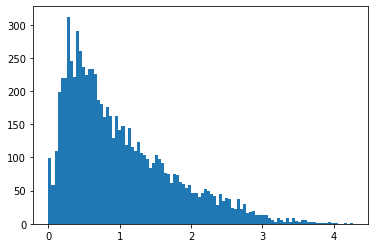

mean:  1.0
var :  0.554758336654917

***** TOV_G *****


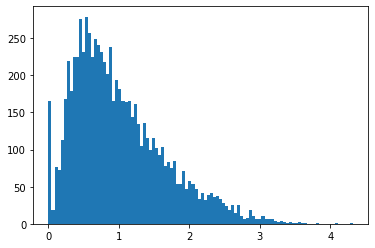

mean:  0.9999999999999999
var :  0.42624267864344695

***** TRB_G *****


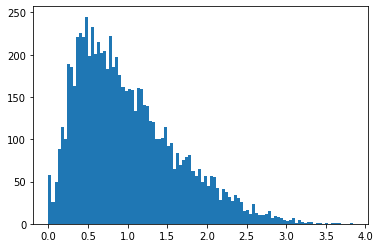

mean:  1.0
var :  0.3964587124208703

***** STL_G *****


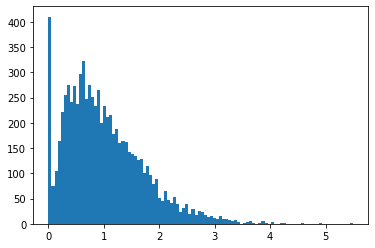

mean:  1.0000000000000002
var :  0.4934361054344179

***** PER_w *****


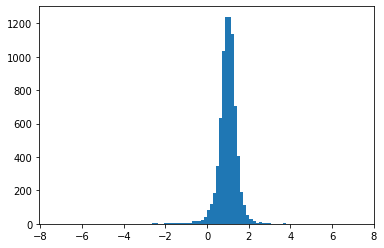

mean:  1.0000000000000002
var :  0.2359092939527459

***** FG% *****


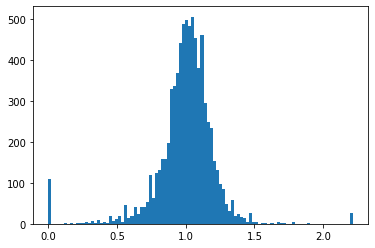

mean:  1.0
var :  0.04723000556591869

***** FT% *****


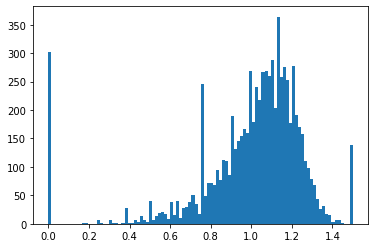

mean:  1.0
var :  0.07816436066416528

***** 3P_G *****


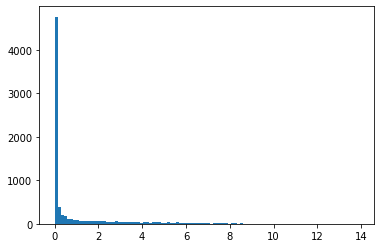

mean:  1.0
var :  3.9245093566794704

***** AST_G *****


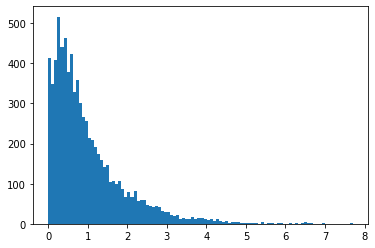

mean:  0.9999999999999998
var :  0.8605029991935753

***** BLK_G *****


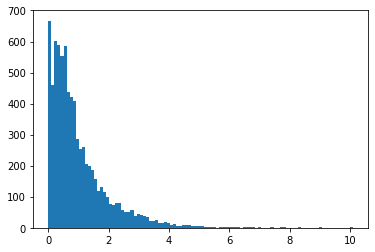

mean:  1.0000000000000002
var :  0.9719715831131128


In [53]:
# distirubition, mean, variance

means = []
variances = []
allMetrics = ["PTS_G","TOV_G","TRB_G","STL_G","PER_w", "FG%","FT%","3P_G","AST_G","BLK_G"]
# offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G"]
# defMetrics = ["TRB_G","STL_G","BLK_G"]
for metric in allMetrics:
    print()
    print("*****", metric, "*****")
    df = allPivotedTableDict[metric]
    vals = df.values.flatten()
    vals = vals[~np.isnan(vals)]
    
    vals = vals/vals.mean()
    
    plt.hist(vals, bins=100)
    plt.show()

    
    means.append(vals.mean())
    variances.append(np.var(vals))
    print("mean: ", vals.mean())
    print("var : ", np.var(vals))

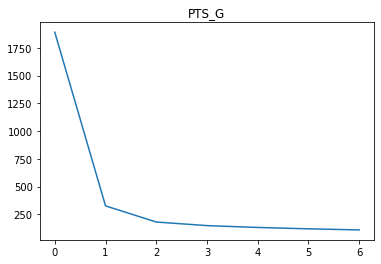

Energy up until 1 th singular value:  0.9459075040806426
Energy up until 2 th singular value:  0.9740526703856459
Energy up until 3 th singular value:  0.982685613574359
Energy up until 4 th singular value:  0.9884945827951014
Energy up until 5 th singular value:  0.9930695719706136
Energy up until 6 th singular value:  0.9968325785826575


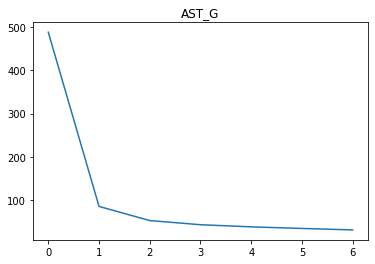

Energy up until 1 th singular value:  0.9394375443868087
Energy up until 2 th singular value:  0.9680060523511369
Energy up until 3 th singular value:  0.9788278423108991
Energy up until 4 th singular value:  0.9860375094041313
Energy up until 5 th singular value:  0.9916833279085845
Energy up until 6 th singular value:  0.9962730105753788


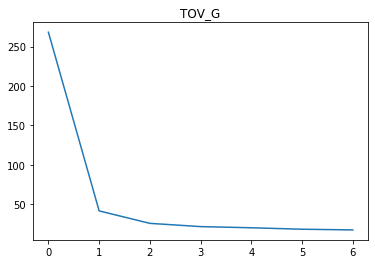

Energy up until 1 th singular value:  0.9480506023562604
Energy up until 2 th singular value:  0.9709507181571525
Energy up until 3 th singular value:  0.9797812585092333
Energy up until 4 th singular value:  0.9860262678033834
Energy up until 5 th singular value:  0.9914499691887503
Energy up until 6 th singular value:  0.9959341333435939


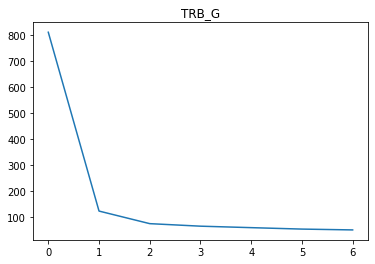

Energy up until 1 th singular value:  0.9524742547876445
Energy up until 2 th singular value:  0.973982803123218
Energy up until 3 th singular value:  0.9817811557669256
Energy up until 4 th singular value:  0.9876461285031914
Energy up until 5 th singular value:  0.9925119875160515
Energy up until 6 th singular value:  0.9964900919322267


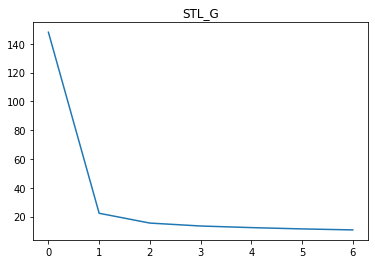

Energy up until 1 th singular value:  0.9430601244663914
Energy up until 2 th singular value:  0.9645394060235551
Energy up until 3 th singular value:  0.9749098828963646
Energy up until 4 th singular value:  0.9827450836288022
Energy up until 5 th singular value:  0.989341181542723
Energy up until 6 th singular value:  0.9950036976154252


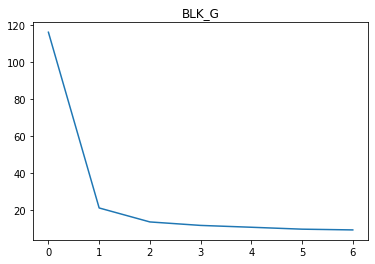

Energy up until 1 th singular value:  0.9250376104277934
Energy up until 2 th singular value:  0.9562254757568363
Energy up until 3 th singular value:  0.9692562561607937
Energy up until 4 th singular value:  0.9789801745589586
Energy up until 5 th singular value:  0.9871498115689654
Energy up until 6 th singular value:  0.9938408718661567


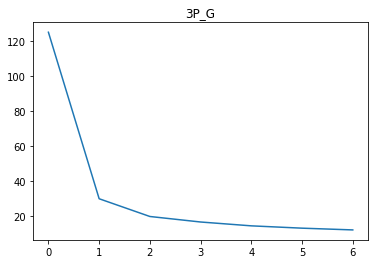

Energy up until 1 th singular value:  0.885070199627972
Energy up until 2 th singular value:  0.9348766356351004
Energy up until 3 th singular value:  0.9563989869377861
Energy up until 4 th singular value:  0.9715130842191232
Energy up until 5 th singular value:  0.9828275064839245
Energy up until 6 th singular value:  0.9921094952103777


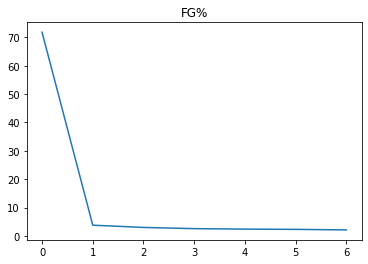

Energy up until 1 th singular value:  0.9913976688112277
Energy up until 2 th singular value:  0.9941197712331162
Energy up until 3 th singular value:  0.9958159869331583
Energy up until 4 th singular value:  0.9970618670708317
Energy up until 5 th singular value:  0.9981481399151786
Energy up until 6 th singular value:  0.9991555149842761


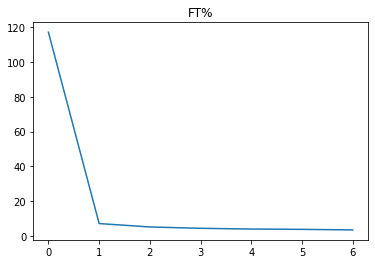

Energy up until 1 th singular value:  0.9891335045654268
Energy up until 2 th singular value:  0.9930072264024358
Energy up until 3 th singular value:  0.9950857248602277
Energy up until 4 th singular value:  0.9966134777503008
Energy up until 5 th singular value:  0.9978712069065522
Energy up until 6 th singular value:  0.999024445802862


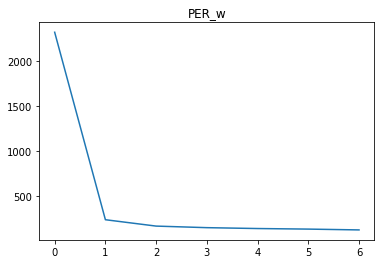

Energy up until 1 th singular value:  0.9709255968485441
Energy up until 2 th singular value:  0.9811875843436213
Energy up until 3 th singular value:  0.9862629772929716
Energy up until 4 th singular value:  0.9903423373941674
Energy up until 5 th singular value:  0.9939110602414083
Energy up until 6 th singular value:  0.9971673435412367


In [8]:
from itertools import combinations, product

pred_year = 2016

################################

# targets to test
activePlayers = getActivePlayers(stats, 2016, 4)
activePlayers.sort()
# to few donors
activePlayers.remove("Kevin Garnett")
activePlayers.remove("Kobe Bryant")

# overall setup
expSetup = ["sliding", "SVD", "all", "pinv", False]
threshold = 0.97

#################################
playerName = activePlayers[5]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)
metrics = allMetrics

target_data = target.concat(metrics, pred_year, pred_length=1)

num_k = len(metrics)
total_index = int(target_data.shape[1] / num_k)
mat_form_method = expSetup[0] # "fixed"

donor_dict = donor.dict(allMetrics, 2016, total_index, method = mat_form_method)

# for each metric

for metric in allMetrics:
    utils.svdAanlysis(donor_dict[metric], title=metric)

['PTS_G', 'AST_G']


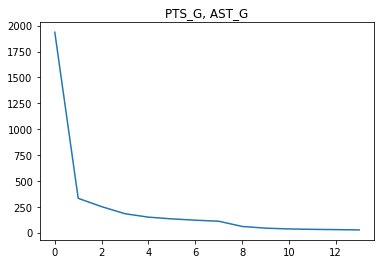

Energy up until 1 th singular value:  0.9298226837394468
Energy up until 2 th singular value:  0.9571176611487049
Energy up until 3 th singular value:  0.9727944216449408
Energy up until 4 th singular value:  0.98108637277266
Energy up until 5 th singular value:  0.9866588369952245
Energy up until 6 th singular value:  0.9910481900375261
['PTS_G', 'TOV_G']


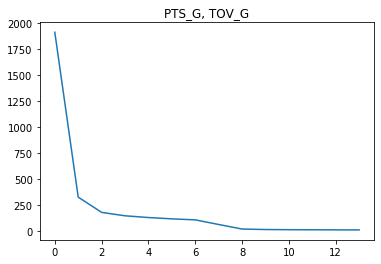

Energy up until 1 th singular value:  0.9448323471101897
Energy up until 2 th singular value:  0.9727494038291646
Energy up until 3 th singular value:  0.9813079564846251
Energy up until 4 th singular value:  0.9870624358596141
Energy up until 5 th singular value:  0.9915971292117975
Energy up until 6 th singular value:  0.9953226997217393
['PTS_G', 'TRB_G']


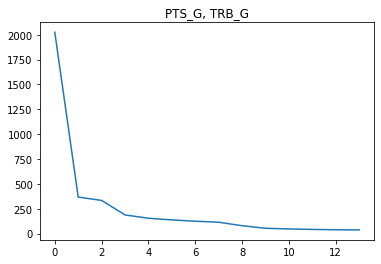

Energy up until 1 th singular value:  0.917580839890141
Energy up until 2 th singular value:  0.9477456046127504
Energy up until 3 th singular value:  0.9726443521056453
Energy up until 4 th singular value:  0.9805109388557823
Energy up until 5 th singular value:  0.9858390858683963
Energy up until 6 th singular value:  0.9900639979560346
['PTS_G', 'STL_G']


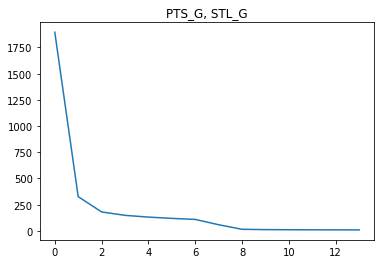

Energy up until 1 th singular value:  0.944983986734538
Energy up until 2 th singular value:  0.9730284322953975
Energy up until 3 th singular value:  0.9816317193832848
Energy up until 4 th singular value:  0.9874205837979236
Energy up until 5 th singular value:  0.9919796292233284
Energy up until 6 th singular value:  0.9957284065863757
['PTS_G', 'BLK_G']


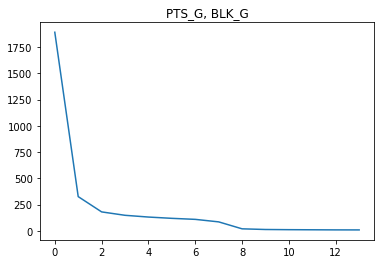

Energy up until 1 th singular value:  0.9438943075829083
Energy up until 2 th singular value:  0.9719553320169679
Energy up until 3 th singular value:  0.980560519050614
Energy up until 4 th singular value:  0.9863508353542751
Energy up until 5 th singular value:  0.9909119448010352
Energy up until 6 th singular value:  0.9946630315894917
['PTS_G', '3P_G']


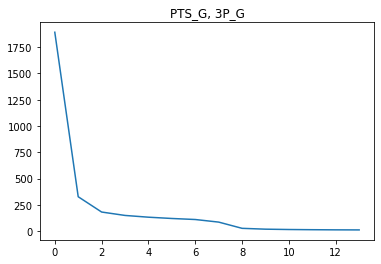

Energy up until 1 th singular value:  0.9437272473591606
Energy up until 2 th singular value:  0.9717997098836659
Energy up until 3 th singular value:  0.9804111568730987
Energy up until 4 th singular value:  0.9862085870666183
Energy up until 5 th singular value:  0.9907739474043711
Energy up until 6 th singular value:  0.994530464024669
['PTS_G', 'FG%']


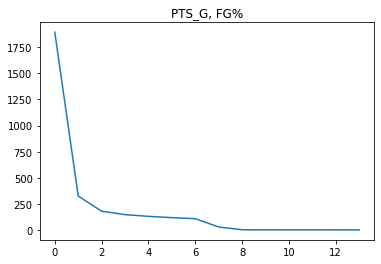

Energy up until 1 th singular value:  0.9457308125796186
Energy up until 2 th singular value:  0.9738403831418986
Energy up until 3 th singular value:  0.9824620313019926
Energy up until 4 th singular value:  0.9882636176698657
Energy up until 5 th singular value:  0.9928324929220393
Energy up until 6 th singular value:  0.9965905726855585
['PTS_G', 'FT%']


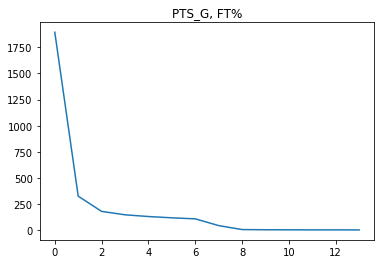

Energy up until 1 th singular value:  0.945522477361659
Energy up until 2 th singular value:  0.9735740022282486
Energy up until 3 th singular value:  0.98217698075461
Energy up until 4 th singular value:  0.98796645737806
Energy up until 5 th singular value:  0.9925250614668485
Energy up until 6 th singular value:  0.9962747622085871
['PTS_G', 'PER_w']


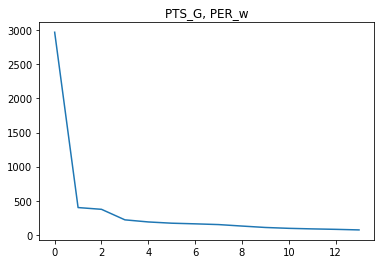

Energy up until 1 th singular value:  0.9439165565251333
Energy up until 2 th singular value:  0.9611348125004466
Energy up until 3 th singular value:  0.976212143545424
Energy up until 4 th singular value:  0.9814396170528433
Energy up until 5 th singular value:  0.9853137333908156
Energy up until 6 th singular value:  0.9884780413677734
['AST_G', 'TOV_G']


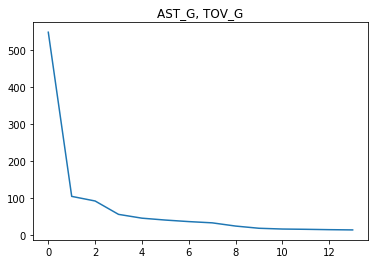

Energy up until 1 th singular value:  0.9085547639922765
Energy up until 2 th singular value:  0.9414510986745449
Energy up until 3 th singular value:  0.966944464665393
Energy up until 4 th singular value:  0.9763081411092047
Energy up until 5 th singular value:  0.9825282185147227
Energy up until 6 th singular value:  0.9874290865533912
['AST_G', 'TRB_G']


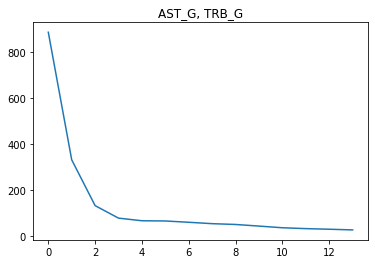

Energy up until 1 th singular value:  0.8321354710589083
Energy up until 2 th singular value:  0.948996920753294
Energy up until 3 th singular value:  0.9677193725924398
Energy up until 4 th singular value:  0.9742758575898224
Energy up until 5 th singular value:  0.9790760240711369
Energy up until 6 th singular value:  0.9837354336310902
['AST_G', 'STL_G']


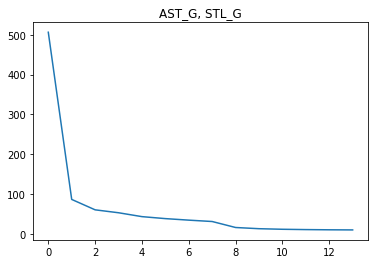

Energy up until 1 th singular value:  0.926576821358285
Energy up until 2 th singular value:  0.9536284983044376
Energy up until 3 th singular value:  0.966800895368671
Energy up until 4 th singular value:  0.9769686399971262
Energy up until 5 th singular value:  0.9837432333495365
Energy up until 6 th singular value:  0.9890498113031303
['AST_G', 'BLK_G']


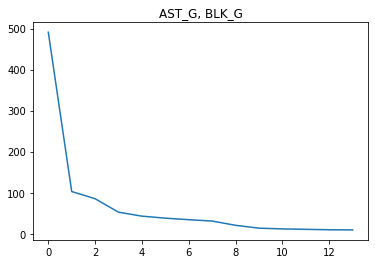

Energy up until 1 th singular value:  0.8992829488671759
Energy up until 2 th singular value:  0.938713782838796
Energy up until 3 th singular value:  0.9658101859710734
Energy up until 4 th singular value:  0.9760657034466896
Energy up until 5 th singular value:  0.9829023828086194
Energy up until 6 th singular value:  0.9882586476861112
['AST_G', '3P_G']


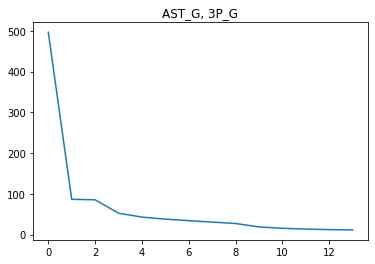

Energy up until 1 th singular value:  0.9084983473542151
Energy up until 2 th singular value:  0.9361771290551847
Energy up until 3 th singular value:  0.9631143501809407
Energy up until 4 th singular value:  0.9732997325938131
Energy up until 5 th singular value:  0.9801214898282208
Energy up until 6 th singular value:  0.9854571105253271
['AST_G', 'FG%']


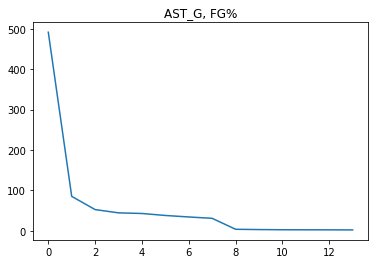

Energy up until 1 th singular value:  0.9329007525416361
Energy up until 2 th singular value:  0.9608998125932252
Energy up until 3 th singular value:  0.9715051507447818
Energy up until 4 th singular value:  0.979090204591853
Energy up until 5 th singular value:  0.9861521182573698
Energy up until 6 th singular value:  0.9916825666182068
['AST_G', 'FT%']


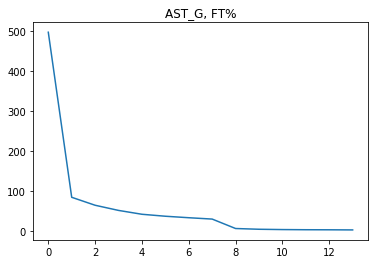

Energy up until 1 th singular value:  0.9260368951228033
Energy up until 2 th singular value:  0.9531701803822829
Energy up until 3 th singular value:  0.9691116907130235
Energy up until 4 th singular value:  0.9793760287293681
Energy up until 5 th singular value:  0.9862122907601537
Energy up until 6 th singular value:  0.991566712891284
['AST_G', 'PER_w']


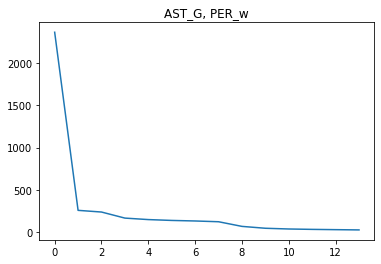

Energy up until 1 th singular value:  0.9581374519531675
Energy up until 2 th singular value:  0.9697883459185125
Energy up until 3 th singular value:  0.9797292253967843
Energy up until 4 th singular value:  0.9846362040369026
Energy up until 5 th singular value:  0.9885789836635125
Energy up until 6 th singular value:  0.9920171560896758
['TOV_G', 'TRB_G']


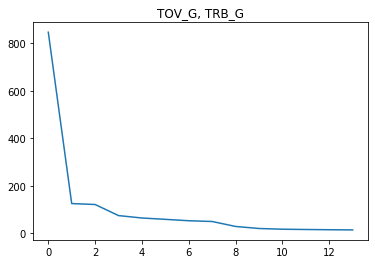

Energy up until 1 th singular value:  0.9327348036636399
Energy up until 2 th singular value:  0.9532781965789362
Energy up until 3 th singular value:  0.972565605960597
Energy up until 4 th singular value:  0.9798986558323133
Energy up until 5 th singular value:  0.9853861058705803
Energy up until 6 th singular value:  0.9899549003051696
['TOV_G', 'STL_G']


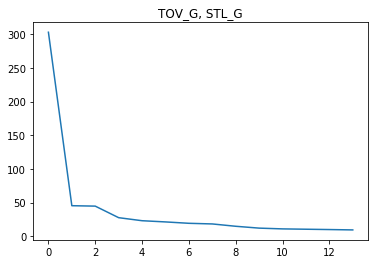

Energy up until 1 th singular value:  0.9262050595164272
Energy up until 2 th singular value:  0.9470090917849444
Energy up until 3 th singular value:  0.9672439297295656
Energy up until 4 th singular value:  0.9749442470652432
Energy up until 5 th singular value:  0.9803349423575437
Energy up until 6 th singular value:  0.9849247408036786
['TOV_G', 'BLK_G']


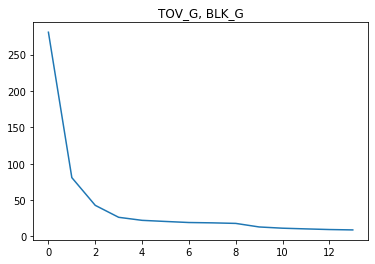

Energy up until 1 th singular value:  0.872103002343557
Energy up until 2 th singular value:  0.9443909414702379
Energy up until 3 th singular value:  0.9645752011583084
Energy up until 4 th singular value:  0.9722037892730483
Energy up until 5 th singular value:  0.9776030252793212
Energy up until 6 th singular value:  0.9822753795524983
['TOV_G', '3P_G']


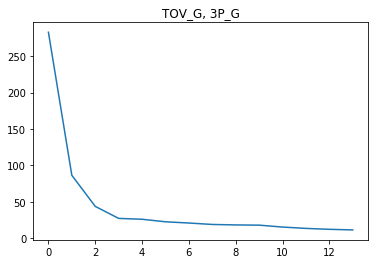

Energy up until 1 th singular value:  0.8563591403620837
Energy up until 2 th singular value:  0.9361962059167852
Energy up until 3 th singular value:  0.956612329632671
Energy up until 4 th singular value:  0.9645224415306337
Energy up until 5 th singular value:  0.9717438495131505
Energy up until 6 th singular value:  0.9771732111131186
['TOV_G', 'FG%']


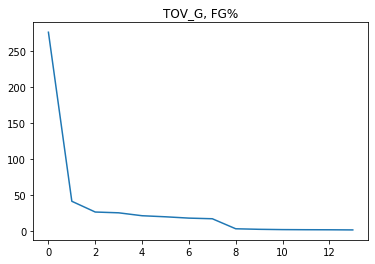

Energy up until 1 th singular value:  0.9418469902993436
Energy up until 2 th singular value:  0.9634083432827567
Energy up until 3 th singular value:  0.9723324575803429
Energy up until 4 th singular value:  0.9805459255442811
Energy up until 5 th singular value:  0.9863870361926048
Energy up until 6 th singular value:  0.991463735914709
['TOV_G', 'FT%']


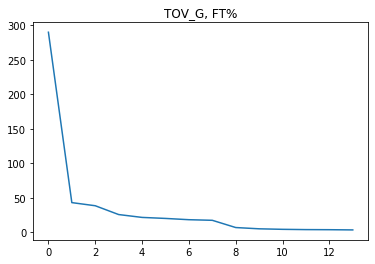

Energy up until 1 th singular value:  0.9363469174991876
Energy up until 2 th singular value:  0.9571391157120603
Energy up until 3 th singular value:  0.9738003016729175
Energy up until 4 th singular value:  0.9812795680022209
Energy up until 5 th singular value:  0.9865612621035876
Energy up until 6 th singular value:  0.9911516822205677
['TOV_G', 'PER_w']


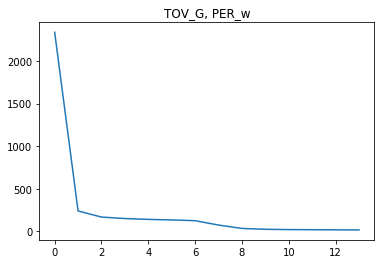

Energy up until 1 th singular value:  0.9696353255740693
Energy up until 2 th singular value:  0.9798435279284127
Energy up until 3 th singular value:  0.9848652362015909
Energy up until 4 th singular value:  0.9888975663116641
Energy up until 5 th singular value:  0.9924210572375515
Energy up until 6 th singular value:  0.995635524465197
['TRB_G', 'STL_G']


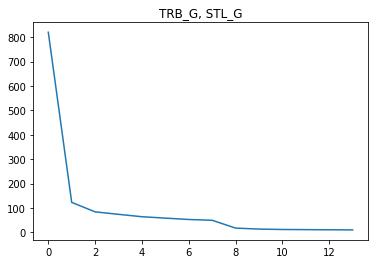

Energy up until 1 th singular value:  0.9423121130659137
Energy up until 2 th singular value:  0.9634089880041965
Energy up until 3 th singular value:  0.973274084934941
Energy up until 4 th singular value:  0.9808944479393251
Energy up until 5 th singular value:  0.9866298331496451
Energy up until 6 th singular value:  0.9913810299732314
['TRB_G', 'BLK_G']


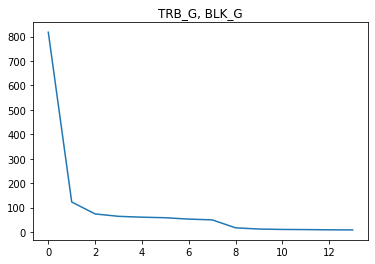

Energy up until 1 th singular value:  0.9467192678303483
Energy up until 2 th singular value:  0.9680307777391125
Energy up until 3 th singular value:  0.9757368515613389
Energy up until 4 th singular value:  0.9815343821957349
Energy up until 5 th singular value:  0.9867150913718997
Energy up until 6 th singular value:  0.9915118272598308
['TRB_G', '3P_G']


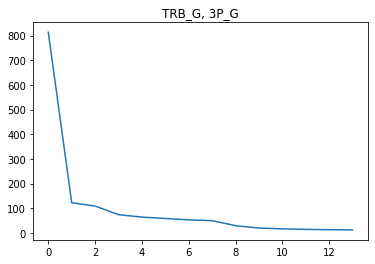

Energy up until 1 th singular value:  0.9341816679849471
Energy up until 2 th singular value:  0.9552342798605917
Energy up until 3 th singular value:  0.9718479902820026
Energy up until 4 th singular value:  0.9794537654742952
Energy up until 5 th singular value:  0.9851860963242602
Energy up until 6 th singular value:  0.989940321205944
['TRB_G', 'FG%']


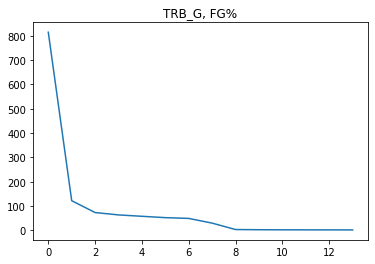

Energy up until 1 th singular value:  0.9514737071305612
Energy up until 2 th singular value:  0.9728286145317053
Energy up until 3 th singular value:  0.9805708528151016
Energy up until 4 th singular value:  0.9863926872037491
Energy up until 5 th singular value:  0.9912229151332711
Energy up until 6 th singular value:  0.9951718202951393
['TRB_G', 'FT%']


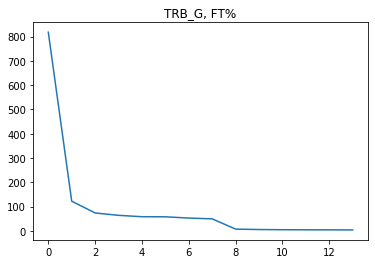

Energy up until 1 th singular value:  0.9484583282583499
Energy up until 2 th singular value:  0.9695778142838946
Energy up until 3 th singular value:  0.977226970170477
Energy up until 4 th singular value:  0.9829799437109216
Energy up until 5 th singular value:  0.987751128174557
Energy up until 6 th singular value:  0.9924602443075127
['TRB_G', 'PER_w']


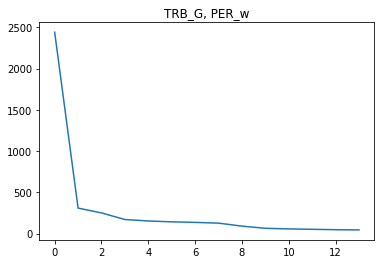

Energy up until 1 th singular value:  0.9535671845259361
Energy up until 2 th singular value:  0.9689107478788014
Energy up until 3 th singular value:  0.9790171781766035
Energy up until 4 th singular value:  0.983708452357566
Energy up until 5 th singular value:  0.9874815218321182
Energy up until 6 th singular value:  0.990758146411626
['STL_G', 'BLK_G']


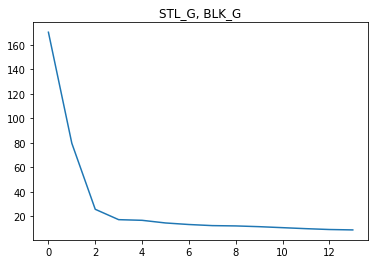

Energy up until 1 th singular value:  0.7684686919395947
Energy up until 2 th singular value:  0.9361664613249555
Energy up until 3 th singular value:  0.9535854609952016
Energy up until 4 th singular value:  0.9613926820053207
Energy up until 5 th singular value:  0.9687239192044504
Energy up until 6 th singular value:  0.9742711677863929
['STL_G', '3P_G']


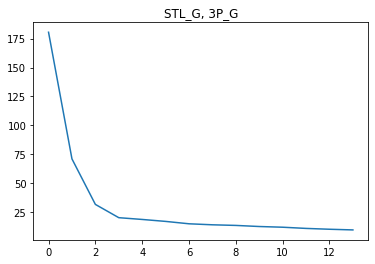

Energy up until 1 th singular value:  0.794766536343166
Energy up until 2 th singular value:  0.9183349089956446
Energy up until 3 th singular value:  0.9431225265534927
Energy up until 4 th singular value:  0.9532864863276149
Energy up until 5 th singular value:  0.9619858488549624
Energy up until 6 th singular value:  0.9692004816972761
['STL_G', 'FG%']


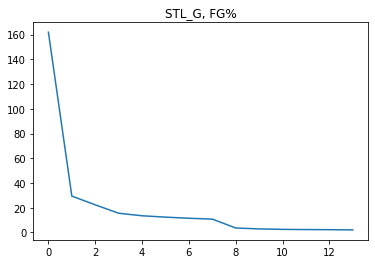

Energy up until 1 th singular value:  0.9215719051942503
Energy up until 2 th singular value:  0.9519548041882865
Energy up until 3 th singular value:  0.9695000402990332
Energy up until 4 th singular value:  0.9779892938182385
Energy up until 5 th singular value:  0.984395815460108
Energy up until 6 th singular value:  0.9897931785907713
['STL_G', 'FT%']


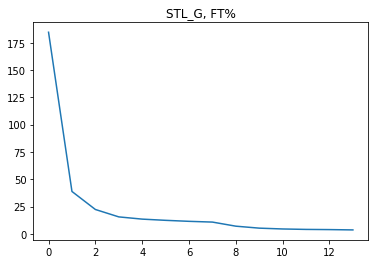

Energy up until 1 th singular value:  0.9196465578615177
Energy up until 2 th singular value:  0.9603452847105118
Energy up until 3 th singular value:  0.9738155889205821
Energy up until 4 th singular value:  0.9803501627728802
Energy up until 5 th singular value:  0.9852785538478585
Energy up until 6 th singular value:  0.9894319876339646
['STL_G', 'PER_w']


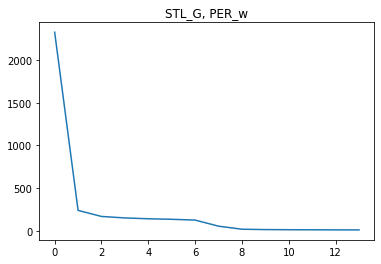

Energy up until 1 th singular value:  0.9702879118417808
Energy up until 2 th singular value:  0.9805351879394709
Energy up until 3 th singular value:  0.9855968991923798
Energy up until 4 th singular value:  0.9896643748827147
Energy up until 5 th singular value:  0.993221706137085
Energy up until 6 th singular value:  0.9964677444170195
['BLK_G', '3P_G']


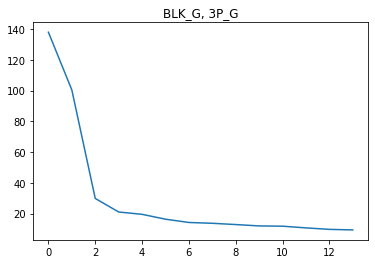

Energy up until 1 th singular value:  0.5903052807619981
Energy up until 2 th singular value:  0.9031238637938689
Energy up until 3 th singular value:  0.9308005004243858
Energy up until 4 th singular value:  0.9445515779269552
Energy up until 5 th singular value:  0.9563830117218979
Energy up until 6 th singular value:  0.9646988949213298
['BLK_G', 'FG%']


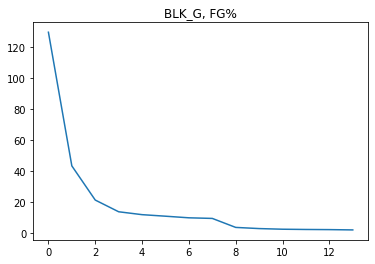

Energy up until 1 th singular value:  0.84757003897287
Energy up until 2 th singular value:  0.9425626702443006
Energy up until 3 th singular value:  0.965543012218924
Energy up until 4 th singular value:  0.9751299279860559
Energy up until 5 th singular value:  0.9822982149525958
Energy up until 6 th singular value:  0.9883195229888374
['BLK_G', 'FT%']


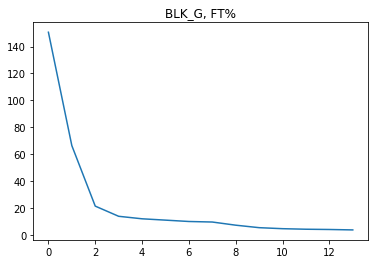

Energy up until 1 th singular value:  0.8010120612113675
Energy up until 2 th singular value:  0.9562954494839289
Energy up until 3 th singular value:  0.9723522301590415
Energy up until 4 th singular value:  0.9790340118459742
Energy up until 5 th singular value:  0.9840302428017836
Energy up until 6 th singular value:  0.9882251482131272
['BLK_G', 'PER_w']


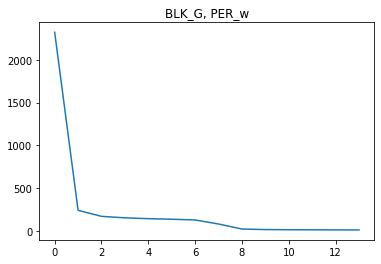

Energy up until 1 th singular value:  0.9697016569702438
Energy up until 2 th singular value:  0.9799491623732229
Energy up until 3 th singular value:  0.9850142150903792
Energy up until 4 th singular value:  0.9890847415570146
Energy up until 5 th singular value:  0.9926455084997114
Energy up until 6 th singular value:  0.9958948997997
['3P_G', 'FG%']


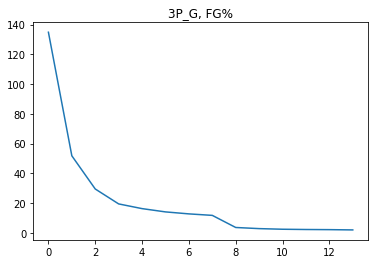

Energy up until 1 th singular value:  0.7924487220072962
Energy up until 2 th singular value:  0.9096424785740019
Energy up until 3 th singular value:  0.9477224481995825
Energy up until 4 th singular value:  0.9643567384230544
Energy up until 5 th singular value:  0.9760469517631504
Energy up until 6 th singular value:  0.9848014176219216
['3P_G', 'FT%']


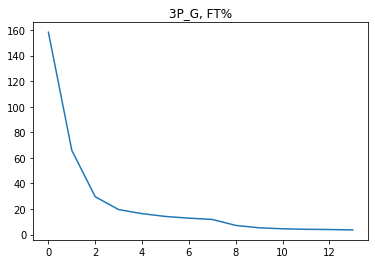

Energy up until 1 th singular value:  0.7936382334033404
Energy up until 2 th singular value:  0.9309208082030441
Energy up until 3 th singular value:  0.9587014641275916
Energy up until 4 th singular value:  0.9708059838827674
Energy up until 5 th singular value:  0.9793122263710287
Energy up until 6 th singular value:  0.985684848593496
['3P_G', 'PER_w']


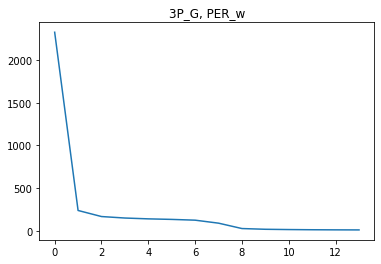

Energy up until 1 th singular value:  0.9691842550402758
Energy up until 2 th singular value:  0.9794339757739589
Energy up until 3 th singular value:  0.9844976521507228
Energy up until 4 th singular value:  0.988567650128674
Energy up until 5 th singular value:  0.9921284768173815
Energy up until 6 th singular value:  0.9953764250829908
['FG%', 'FT%']


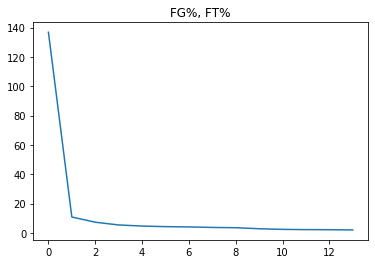

Energy up until 1 th singular value:  0.983709289121778
Energy up until 2 th singular value:  0.9898812933007792
Energy up until 3 th singular value:  0.9926672926021863
Energy up until 4 th singular value:  0.9942066365061444
Energy up until 5 th singular value:  0.9953482876144863
Energy up until 6 th singular value:  0.9963035157508693
['FG%', 'PER_w']


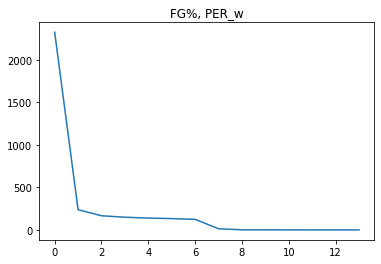

Energy up until 1 th singular value:  0.9709012208260632
Energy up until 2 th singular value:  0.9811561788784989
Energy up until 3 th singular value:  0.9862274763555171
Energy up until 4 th singular value:  0.9903035464833667
Energy up until 5 th singular value:  0.9938693912263206
Energy up until 6 th singular value:  0.9971230355004002
['FT%', 'PER_w']


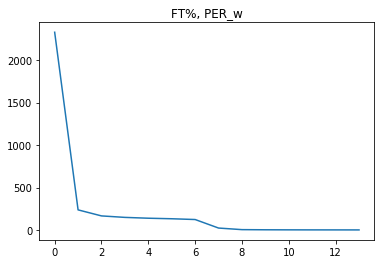

Energy up until 1 th singular value:  0.9708506228049888
Energy up until 2 th singular value:  0.9810937359582022
Energy up until 3 th singular value:  0.9861571953371794
Energy up until 4 th singular value:  0.9902270673413234
Energy up until 5 th singular value:  0.9937874554549623
Energy up until 6 th singular value:  0.9970360712006673


In [9]:
# for 2 metric combinations

comb = combinations(allMetrics,2)

for c in list(comb):
    metrics = list(c)
    print(metrics)
    title = ", "
    title = title.join(metrics)
    df = donor.concat(metrics, 2016, total_index, method = mat_form_method)

    utils.svdAanlysis(df, title=title)

['PTS_G', 'PTS_G']


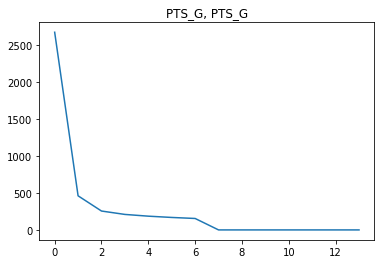

Energy up until 1 th singular value:  0.9459075040806426
Energy up until 2 th singular value:  0.9740526703856458
Energy up until 3 th singular value:  0.9826856135743589
Energy up until 4 th singular value:  0.9884945827951012
Energy up until 5 th singular value:  0.9930695719706135
Energy up until 6 th singular value:  0.9968325785826574
['PTS_G', 'AST_G']


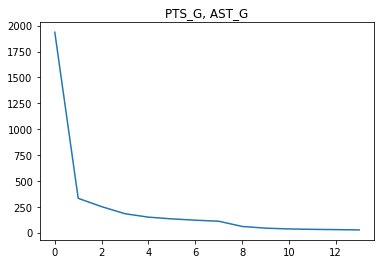

Energy up until 1 th singular value:  0.9298226837394468
Energy up until 2 th singular value:  0.9571176611487049
Energy up until 3 th singular value:  0.9727944216449408
Energy up until 4 th singular value:  0.98108637277266
Energy up until 5 th singular value:  0.9866588369952245
Energy up until 6 th singular value:  0.9910481900375261
['PTS_G', 'TOV_G']


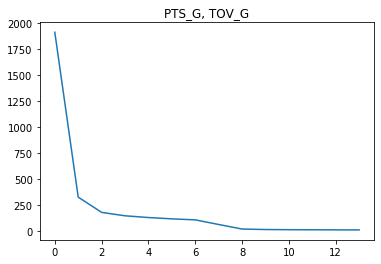

Energy up until 1 th singular value:  0.9448323471101897
Energy up until 2 th singular value:  0.9727494038291646
Energy up until 3 th singular value:  0.9813079564846251
Energy up until 4 th singular value:  0.9870624358596141
Energy up until 5 th singular value:  0.9915971292117975
Energy up until 6 th singular value:  0.9953226997217393
['PTS_G', 'TRB_G']


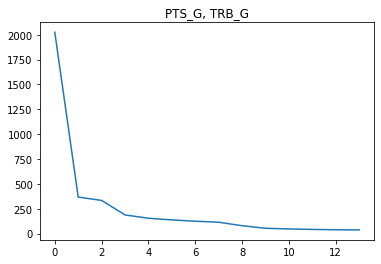

Energy up until 1 th singular value:  0.917580839890141
Energy up until 2 th singular value:  0.9477456046127504
Energy up until 3 th singular value:  0.9726443521056453
Energy up until 4 th singular value:  0.9805109388557823
Energy up until 5 th singular value:  0.9858390858683963
Energy up until 6 th singular value:  0.9900639979560346
['PTS_G', 'STL_G']


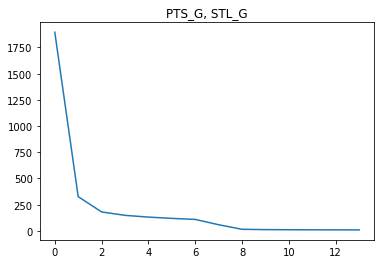

Energy up until 1 th singular value:  0.944983986734538
Energy up until 2 th singular value:  0.9730284322953975
Energy up until 3 th singular value:  0.9816317193832848
Energy up until 4 th singular value:  0.9874205837979236
Energy up until 5 th singular value:  0.9919796292233284
Energy up until 6 th singular value:  0.9957284065863757
['PTS_G', 'BLK_G']


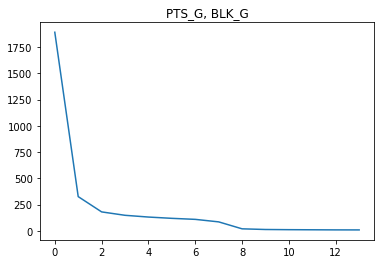

Energy up until 1 th singular value:  0.9438943075829083
Energy up until 2 th singular value:  0.9719553320169679
Energy up until 3 th singular value:  0.980560519050614
Energy up until 4 th singular value:  0.9863508353542751
Energy up until 5 th singular value:  0.9909119448010352
Energy up until 6 th singular value:  0.9946630315894917
['PTS_G', '3P_G']


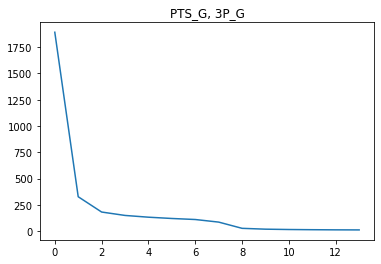

Energy up until 1 th singular value:  0.9437272473591606
Energy up until 2 th singular value:  0.9717997098836659
Energy up until 3 th singular value:  0.9804111568730987
Energy up until 4 th singular value:  0.9862085870666183
Energy up until 5 th singular value:  0.9907739474043711
Energy up until 6 th singular value:  0.994530464024669
['PTS_G', 'FG%']


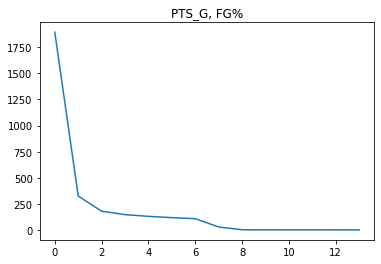

Energy up until 1 th singular value:  0.9457308125796186
Energy up until 2 th singular value:  0.9738403831418986
Energy up until 3 th singular value:  0.9824620313019926
Energy up until 4 th singular value:  0.9882636176698657
Energy up until 5 th singular value:  0.9928324929220393
Energy up until 6 th singular value:  0.9965905726855585
['PTS_G', 'FT%']


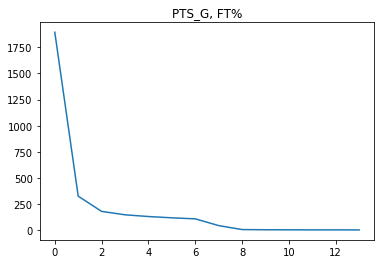

Energy up until 1 th singular value:  0.945522477361659
Energy up until 2 th singular value:  0.9735740022282486
Energy up until 3 th singular value:  0.98217698075461
Energy up until 4 th singular value:  0.98796645737806
Energy up until 5 th singular value:  0.9925250614668485
Energy up until 6 th singular value:  0.9962747622085871
['PTS_G', 'PER_w']


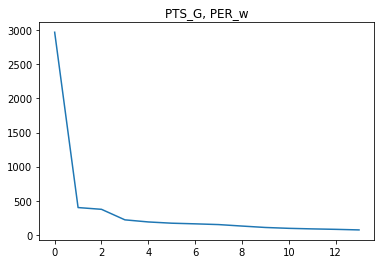

Energy up until 1 th singular value:  0.9439165565251333
Energy up until 2 th singular value:  0.9611348125004466
Energy up until 3 th singular value:  0.976212143545424
Energy up until 4 th singular value:  0.9814396170528433
Energy up until 5 th singular value:  0.9853137333908156
Energy up until 6 th singular value:  0.9884780413677734


In [45]:
# for 2 metric combinations, with 'PTS_G'

comb = product(['PTS_G'],allMetrics)

for c in list(comb):
    metrics = list(c)
    print(metrics)
    title = ", "
    title = title.join(metrics)
    df = donor.concat(metrics, 2016, total_index, method = mat_form_method)

    utils.svdAanlysis(df, title=title)

In [48]:
# for 2 metric combinations, with 'PTS_G'

comb = product(['PTS_G'],allMetrics)


metrics = ['PTS_G','PTS_G']
df = donor.concat(metrics, 2016, total_index, method = mat_form_method)

In [57]:
a = df.iloc[:,0:7]
b = df.iloc[:,7:]
np.sum(a.values - b.values)

0.0

In [44]:
# how to group them?

threshold = 0.97

metric_of_interst = [allMetrics[0]]
potential_group = allMetrics[1:]
comb = list(combinations(potential_group,4))

X = donor.concat(metric_of_interst, 2016, total_index, method = mat_form_method)
rank = utils.approximate_rank(X, t = threshold)

for c in list(comb):
    metrics_to_append = list(c)
    metrics = metric_of_interst + metrics_to_append
    title = ", "
    title = title.join(metrics)
    df = donor.concat(metrics, 2016, total_index, method = mat_form_method)

    energy = utils.svdAanlysis(df, k=rank, title=title, verbose=False)[-1]
    if energy > threshold:
        print(metrics)

['PTS_G', 'TOV_G', 'STL_G', 'FG%', 'FT%']
['PTS_G', 'TOV_G', 'BLK_G', 'FG%', 'FT%']
['PTS_G', 'STL_G', 'BLK_G', 'FG%', 'FT%']
['PTS_G', 'STL_G', '3P_G', 'FG%', 'FT%']


In [38]:
metric_of_interst

'PTS_G'

In [6]:
np.sort(stats.Pos.unique())

array(['C', 'C-PF', 'C-SF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SF', 'PG-SG',
       'SF', 'SF-PF', 'SF-SG', 'SG', 'SG-PF', 'SG-PG', 'SG-SF'],
      dtype=object)

['C', 'SF', 'PF', 'C-PF', 'PF-C', 'C-SF', 'SF-C', 'SF-PF', 'PF-SF']


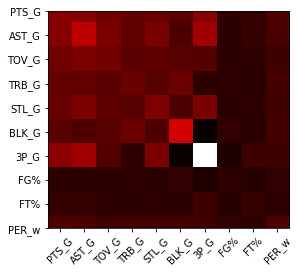

['SG', 'SF', 'PG', 'SG-SF', 'SF-SG', 'SF-PG', 'PG-SF', 'SG-PG', 'PG-SF']


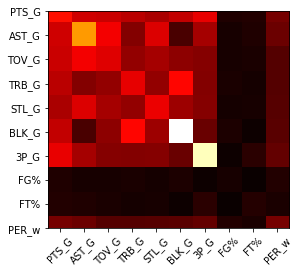

['SG', 'SF', 'PF', 'SG-SF', 'SF-SG', 'SF-PF', 'PF-SF', 'SG-PF', 'PF-SG']


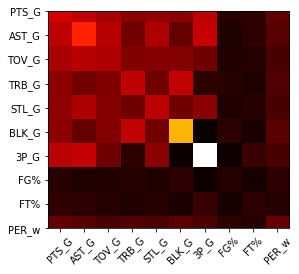

In [7]:
group1 = ["C", "SF","PF", "C-PF", "PF-C", "C-SF", "SF-C", "SF-PF", "PF-SF"]
group2 = ["SG","SF","PG", "SG-SF", "SF-SG", "SF-PG", "PG-SF", "SG-PG", "PG-SF"]
group3 = ["SG","SF","PF", "SG-SF", "SF-SG", "SF-PF", "PF-SF", "SG-PF", "PF-SG"]

groups = [group1, group2, group3]

for group in groups:
    print(group)
    stats_group = stats[stats.Pos.isin(group)]

    ###################################
    metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
    metricsPerGameDict = getMetricsPerGameDict(stats_group, metricsPerGameColNames)

    metricsPerCentColNames = ["FG","FT"]
    metricsPerCentDict = getMetricsPerCentDict(stats_group, metricsPerCentColNames)

    metricsWeightedColNames = ["PER"]
    metricsWeightedDict = getMetricsWeightedDict(stats_group, metricsWeightedColNames)

    allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    allMetrics = list(allMetricsDict.keys())

    X = pd.DataFrame()

    for metric in allMetrics:
        X = pd.concat([X, allMetricsDict[metric].T], axis=0)

    X_norm = X.div(X.mean(axis=1).values, axis=0)
    X_cov = pd.DataFrame(np.cov(X_norm), columns = allMetrics, index = allMetrics).round(3)
    plt.imshow(X_cov, cmap='hot', interpolation='nearest')
    plt.xticks(range(10), allMetrics, rotation=45)
    plt.yticks(range(10), allMetrics)
    plt.show()

In [8]:
# players' stat before pred_year, who played a similar position (in the same group)
pred_year = 2016
playerName = "Al Jefferson"

##############################
stats[stats.Player == playerName] # he is C
relavant_stats = stats[stats.Pos.isin(group1) & (stats.Year < pred_year)]

metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
metricsPerGameDict = getMetricsPerGameDict(relavant_stats, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT"]
metricsPerCentDict = getMetricsPerCentDict(relavant_stats, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(relavant_stats, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
allPivotedTableDict = getPivotedTableDict(allMetricsDict)
allMetrics = list(allMetricsDict.keys())



df = pd.DataFrame()
for metric in allMetrics:
    vals = allPivotedTableDict[metric][df_year < 2016].values.flatten()
    vals = vals[~np.isnan(vals)]
    df_metric = pd.DataFrame(vals, columns = [metric])
    df = pd.concat([df,df_metric], axis=1)
df

,PTS_G,AST_G,TOV_G,TRB_G,STL_G,BLK_G,3P_G,FG%,FT%,PER_w
0,6.353659,0.658537,1.207317,4.646341,0.597561,0.597561,0.012195,0.538660,0.610778,11.8
1,10.784810,1.063291,1.291139,7.784810,0.886076,1.012658,0.000000,0.538330,0.780142,15.7
2,11.426829,1.134146,1.463415,8.658537,1.060976,0.548780,0.000000,0.503125,0.773087,14.5
3,13.268293,1.256098,1.451220,9.012195,1.146341,0.670732,0.048780,0.529024,0.785515,17.8
4,12.939024,1.097561,1.414634,8.682927,0.804878,0.609756,0.158537,0.477667,0.751351,14.7
...,...,...,...,...,...,...,...,...,...,...
7710,11.858974,1.576923,1.807692,7.679487,0.615385,1.256410,0.000000,0.485498,0.807292,18.0
7711,14.095890,1.424658,1.849315,9.342466,0.465753,1.643836,0.000000,0.474403,0.802469,18.7
7712,12.892308,0.984615,1.384615,7.538462,0.430769,1.292308,0.230769,0.472376,0.798851,18.0
7713,7.406250,0.750000,0.984375,5.390625,0.218750,0.781250,0.171875,0.442922,0.742574,11.9


(10, 2)


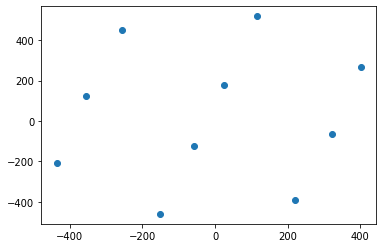

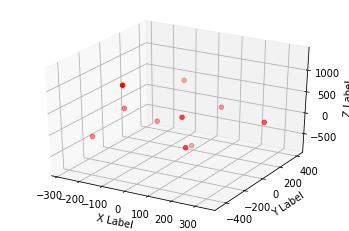

In [11]:
from sklearn.manifold import TSNE
X = df.T.values
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)

plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

##########################

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=3).fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =X_embedded[:,0]
y =X_embedded[:,1]
z =X_embedded[:,2]

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

(10, 2)


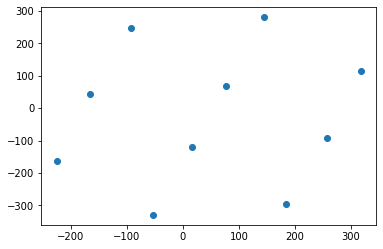

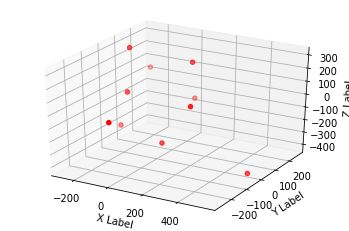

In [36]:
# for the target only
target = Target(playerName, allPivotedTableDict, df_year)

target_dict = target.dict(allMetrics, pred_year-1)
df = pd.DataFrame()
for metric in allMetrics:
    df = pd.concat([df,target_dict[metric]], axis=0)

X = df.values
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)


plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

##########################

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=3).fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =X_embedded[:,0]
y =X_embedded[:,1]
z =X_embedded[:,2]

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [37]:
x

array([-221.59985 , -149.97813 , -274.1259  ,  547.3848  ,  234.3854  ,
       -209.149   ,  -19.201603,   75.559006,  108.13452 ,   34.759438],
      dtype=float32)

In [38]:
y

array([  74.61635  ,  -19.001015 ,  259.33804  ,  -23.924458 ,
        -41.39379  ,   -3.3214805, -268.2625   ,  150.98026  ,
        -83.13696  ,  213.47731  ], dtype=float32)

In [39]:
z

array([ 303.80417  ,   40.086964 ,   28.816696 , -413.03818  ,
         37.006287 , -244.77316  ,    6.5839906,  213.38007  ,
       -248.47957  , -115.73303  ], dtype=float32)

In [40]:
X_embedded

array([[-221.59985  ,   74.61635  ,  303.80417  ],
       [-149.97813  ,  -19.001015 ,   40.086964 ],
       [-274.1259   ,  259.33804  ,   28.816696 ],
       [ 547.3848   ,  -23.924458 , -413.03818  ],
       [ 234.3854   ,  -41.39379  ,   37.006287 ],
       [-209.149    ,   -3.3214805, -244.77316  ],
       [ -19.201603 , -268.2625   ,    6.5839906],
       [  75.559006 ,  150.98026  ,  213.38007  ],
       [ 108.13452  ,  -83.13696  , -248.47957  ],
       [  34.759438 ,  213.47731  , -115.73303  ]], dtype=float32)

In [42]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_embedded)
distances, indices = nbrs.kneighbors(X_embedded)

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_embedded)
kmeans.labels_

array([1, 1, 1, 2, 0, 0, 0, 1, 0, 0], dtype=int32)

In [52]:
allMetrics

['PTS_G',
 'AST_G',
 'TOV_G',
 'TRB_G',
 'STL_G',
 'BLK_G',
 '3P_G',
 'FG%',
 'FT%',
 'PER_w']